# For Push-Ups, Extract the frames from each videos

In [ ]:
import cv2
import os

In [ ]:
video_folder = "./Push-Up Models/Pushup Videos/Correct sequence" # folder for pushups Correct and Wrong sequence
frame_output_folder = "./Push-Up Models/Pushup Correct Frames"

In [ ]:
os.makedirs(frame_output_folder, exist_ok=True)

frame_interval = 30  # Extract every nth frame

In [ ]:
for video_file in os.listdir(video_folder):
    if video_file.endswith(".mp4"):  # Add other formats if necessary
        cap = cv2.VideoCapture(os.path.join(video_folder, video_file))
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_interval == 0:
                frame_name = f"{frame_output_folder}/{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg"
                cv2.imwrite(frame_name, frame)
            frame_count += 1
        cap.release()

In [ ]:
print("Frames extracted successfully!")

# Resize and Add Padding to the Images
This is so they all have the same size of 800 x 600

In [3]:
from PIL import Image, ImageOps
import os

In [4]:
def resize_and_pad_images(input_folder, output_folder, target_size=(800, 600), background_color=(255, 255, 255)):
    """
    Resize images and place them on a plain background of the specified size.

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder to save output images.
        target_size (tuple): Target size (width, height) for the output images.
        background_color (tuple): Background color as an RGB tuple.
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'JPG')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the image
            with Image.open(input_path) as img:
                # Resize image to fit within the target size while maintaining aspect ratio
                img.thumbnail((target_size[0], target_size[1]))

                # Create a new image with the target size and background color
                background = Image.new('RGB', target_size, background_color)

                # Calculate position to center the image on the background
                x_offset = (target_size[0] - img.width) // 2
                y_offset = (target_size[1] - img.height) // 2

                # Paste the resized image onto the background
                background.paste(img, (x_offset, y_offset))

                # Save the output image
                background.save(output_path)

    print(f"Processed images are saved in: {output_folder}")

In [6]:
# Example usage
input_folder = "./Data/Pushup Wrong Frames" # Replace with the path to your input folder
output_folder = "./Data/resized_images/wrong"  # Replace with the path to your output folder
resize_and_pad_images(input_folder, output_folder)

Processed images are saved in: ./Data/resized_images/wrong


# Extract the Landmarks from each Frames and save them in a CSV file

For the landmarks, put them in a folder called "Processed Images", and the numbers in a CSV

In [ ]:
import cv2
import mediapipe as mp
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
def extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir):
    """
    Extract pose landmarks, overlay them on images, and handle incomplete detections.

    Args:
        frames_dir (str): Directory containing input images.
        output_csv (str): Path to the output CSV file for landmarks.
        output_images_dir (str): Directory to save images with landmarks overlayed.

    """
    # Initialize MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, model_complexity=2)
    mp_drawing = mp.solutions.drawing_utils

    # Get landmark names
    landmark_names = [landmark.name for landmark in mp_pose.PoseLandmark]

    # Prepare the output CSV column names
    columns = ["frame"] + [f"{name}_{axis}" for name in landmark_names for axis in ["x", "y", "z", "visibility"]]
    data = []

    # Create output directory if it doesn't exist
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)

    # Track problematic frames
    problematic_frames = []

    # Process each frame
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png', '.JPG'))])
    for frame_file in tqdm(frame_files, desc="Processing frames"):
        frame_path = os.path.join(frames_dir, frame_file)
        image = cv2.imread(frame_path)
        if image is None:
            print(f"Warning: Unable to read image {frame_file}. Skipping...")
            problematic_frames.append(frame_file)
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Extract landmarks
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])

            # Check if all landmarks are detected (non-zero visibility)
            all_visible = all(lm.visibility > 0 for lm in results.pose_landmarks.landmark)

            if not all_visible:
                print(f"Incomplete detection in {frame_file}. Skipping...")
                problematic_frames.append(frame_file)
                continue

            # Save landmarks data
            data.append([frame_file] + landmarks)

            # Draw landmarks on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Save the processed image with landmarks overlayed
            output_image_path = os.path.join(output_images_dir, frame_file)
            cv2.imwrite(output_image_path, image)

        else:
            print(f"No landmarks detected in {frame_file}. Skipping...")
            problematic_frames.append(frame_file)

    # Save landmarks to CSV
    if data:
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(output_csv, index=False)
        print(f"Landmarks saved to {output_csv}")
    else:
        print("No valid landmarks were detected.")

    # Print problematic frames
    if problematic_frames:
        print("Frames with issues:")
        for frame in problematic_frames:
            print(f" - {frame}")

        # Optionally, delete problematic frames from the output directory
        for frame in problematic_frames:
            output_image_path = os.path.join(output_images_dir, frame)
            if os.path.exists(output_image_path):
                os.remove(output_image_path)

    print(f"Processed images saved to {output_images_dir}")

In [ ]:
if __name__ == "__main__":
    # Path to frames directory
    frames_dir = "./Pushup/Pushup Correct Frames"
    # Path to output CSV file
    output_csv = "./Cleaned Data/Pushup CSV/correct_pose_landmarks.csv"
    # Path to output directory for processed images
    output_images_dir = "./Processed Images/Pushup Frames/Correct Frames"

    # Extract pose landmarks and overlay them on images
    extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir)

# [old] Combine Correct CSV and Wrong CSV

After extracting both correct and wrong frames, combine them into one CSV file

In [2]:
import pandas as pd

In [8]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [10]:
# Load both CSV files
correct_df = pd.read_csv('./Data/cleaned_data/separate/correct_landmarks.csv')
incorrect_df = pd.read_csv('./Data/cleaned_data/separate/incorrect_landmarks.csv')

In [11]:
# Add a 'label' column to each DataFrame
correct_df['label'] = 'correct'
incorrect_df['label'] = 'incorrect'

In [12]:
# Filter out columns related to excluded landmarks
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [13]:
# Apply the filter to both DataFrames
correct_df = filter_landmarks(correct_df, excluded_landmarks)
incorrect_df = filter_landmarks(incorrect_df, excluded_landmarks)

In [14]:
# Combine the DataFrames
combined_df = pd.concat([correct_df, incorrect_df], ignore_index=True)

In [15]:
# Save the combined dataset to a new CSV file
combined_df.to_csv('./Data/cleaned_data/combined/pushup_complete.csv', index=False)

In [16]:
print("Combined dataset saved as 'pushup_complete.csv'")

Combined dataset saved as 'pushup_complete.csv'


# Final Touch-ups

In [3]:
new_pushup_correct = pd.read_csv("./Data/cleaned_data/NEW/pushup_correct_landmarks.csv")
new_pushup_high = pd.read_csv("./Data/cleaned_data/NEW/pushup_high_landmarks.csv")
new_pushup_low = pd.read_csv("./Data/cleaned_data/NEW/pushup_low_landmarks.csv")

In [4]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [5]:
# Filter out columns related to excluded landmarks
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [6]:
new_pushup_correct = filter_landmarks(new_pushup_correct, excluded_landmarks)
new_pushup_high = filter_landmarks(new_pushup_high, excluded_landmarks)
new_pushup_low = filter_landmarks(new_pushup_low, excluded_landmarks)

In [ ]:
# Concatenate them along the rows
new_pushup = pd.concat([new_pushup_correct, new_pushup_high, new_pushup_low], ignore_index=True)
new_pushup

,frame,label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,Copy of push up 100_frame_0.jpg,Good-pushup,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,...,0.193960,0.311754,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263
1,Copy of push up 100_frame_100.jpg,Good-pushup,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,...,0.200884,0.186962,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964
2,Copy of push up 100_frame_75.jpg,Good-pushup,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,...,0.109897,0.497230,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839
3,Copy of push up 101_frame_0.jpg,Good-pushup,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,...,0.191700,0.210666,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808
4,Copy of push up 101_frame_25.jpg,Good-pushup,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,...,0.117686,0.418174,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,IMG_8538.JPG,Too-low-pushup,0.675010,0.560963,0.196668,0.999988,0.702641,0.599055,-0.189740,0.999992,...,-0.164536,0.999263,0.239687,0.789187,0.325010,0.985099,0.200440,0.824689,-0.254344,0.999629
1047,IMG_8539.JPG,Too-low-pushup,0.669068,0.562740,0.177964,0.999980,0.694838,0.602698,-0.213810,0.999977,...,-0.094472,0.994098,0.230255,0.786919,0.376017,0.916131,0.188258,0.825617,-0.183871,0.997044
1048,IMG_8540.JPG,Too-low-pushup,0.664802,0.558682,0.172667,0.999982,0.689151,0.599093,-0.205798,0.999987,...,-0.136298,0.998097,0.232620,0.793573,0.368615,0.972747,0.195949,0.825521,-0.234169,0.999166
1049,IMG_8541.JPG,Too-low-pushup,0.661591,0.551450,0.208848,0.999980,0.686181,0.578994,-0.194285,0.999989,...,-0.172454,0.997589,0.228529,0.793082,0.312156,0.963971,0.196468,0.829084,-0.284098,0.998833


In [12]:
new_pushup.rename({"label": "error-label"}, axis=1, inplace=True)
new_pushup.head()

,frame,error-label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,Copy of push up 100_frame_0.jpg,Good-pushup,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,...,0.193960,0.311754,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263
1,Copy of push up 100_frame_100.jpg,Good-pushup,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,...,0.200884,0.186962,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964
2,Copy of push up 100_frame_75.jpg,Good-pushup,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,...,0.109897,0.497230,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839
3,Copy of push up 101_frame_0.jpg,Good-pushup,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,...,0.191700,0.210666,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808
4,Copy of push up 101_frame_25.jpg,Good-pushup,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,...,0.117686,0.418174,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603


In [13]:
new_pushup['pose-label'] = new_pushup['error-label'].apply(lambda x: 'correct' if x == 'Good-pushup' else 'incorrect')
new_pushup.head()

,frame,error-label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label
0,Copy of push up 100_frame_0.jpg,Good-pushup,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,...,0.311754,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263,correct
1,Copy of push up 100_frame_100.jpg,Good-pushup,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,...,0.186962,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964,correct
2,Copy of push up 100_frame_75.jpg,Good-pushup,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,...,0.497230,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839,correct
3,Copy of push up 101_frame_0.jpg,Good-pushup,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,...,0.210666,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808,correct
4,Copy of push up 101_frame_25.jpg,Good-pushup,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,...,0.418174,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603,correct


In [14]:
# Get the second column (label column)
label_column = new_pushup.columns[1]

# Move the second column to the end
new_pushup = new_pushup[[col for col in new_pushup.columns if col != label_column] + [label_column]]
new_pushup

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Copy of push up 100_frame_0.jpg,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,0.359397,...,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263,correct,Good-pushup
1,Copy of push up 100_frame_100.jpg,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,0.359599,...,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964,correct,Good-pushup
2,Copy of push up 100_frame_75.jpg,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,0.381066,...,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839,correct,Good-pushup
3,Copy of push up 101_frame_0.jpg,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,0.353155,...,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808,correct,Good-pushup
4,Copy of push up 101_frame_25.jpg,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,0.378535,...,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603,correct,Good-pushup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,IMG_8538.JPG,0.675010,0.560963,0.196668,0.999988,0.702641,0.599055,-0.189740,0.999992,0.621789,...,0.239687,0.789187,0.325010,0.985099,0.200440,0.824689,-0.254344,0.999629,incorrect,Too-low-pushup
1047,IMG_8539.JPG,0.669068,0.562740,0.177964,0.999980,0.694838,0.602698,-0.213810,0.999977,0.619363,...,0.230255,0.786919,0.376017,0.916131,0.188258,0.825617,-0.183871,0.997044,incorrect,Too-low-pushup
1048,IMG_8540.JPG,0.664802,0.558682,0.172667,0.999982,0.689151,0.599093,-0.205798,0.999987,0.623783,...,0.232620,0.793573,0.368615,0.972747,0.195949,0.825521,-0.234169,0.999166,incorrect,Too-low-pushup
1049,IMG_8541.JPG,0.661591,0.551450,0.208848,0.999980,0.686181,0.578994,-0.194285,0.999989,0.623973,...,0.228529,0.793082,0.312156,0.963971,0.196468,0.829084,-0.284098,0.998833,incorrect,Too-low-pushup


In [20]:
# Map 'correct' to 1 and 'incorrect' to 0 in the label column
new_pushup['pose-label'] = new_pushup['pose-label'].map({'correct': 1, 'incorrect': 0})

print("Label column values converted to 0 and 1.")
new_pushup.head()

Label column values converted to 0 and 1.


,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Copy of push up 100_frame_0.jpg,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,0.359397,...,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263,1,Good-pushup
1,Copy of push up 100_frame_100.jpg,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,0.359599,...,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964,1,Good-pushup
2,Copy of push up 100_frame_75.jpg,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,0.381066,...,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839,1,Good-pushup
3,Copy of push up 101_frame_0.jpg,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,0.353155,...,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808,1,Good-pushup
4,Copy of push up 101_frame_25.jpg,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,0.378535,...,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603,1,Good-pushup


In [22]:
# Replace 'Good-pushup' in the 'error-label' column with the text 'None'
new_pushup.loc[new_pushup['error-label'] == 'Good-pushup', 'error-label'] = 'None'

print("Rows with 'Good-pushup' updated to 'None' in the 'error-label' column.")
new_pushup

Rows with 'Good-pushup' updated to 'None' in the 'error-label' column.


,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,Copy of push up 100_frame_0.jpg,0.341504,0.490139,-0.127909,0.999970,0.365850,0.475095,0.252014,0.999880,0.359397,...,0.703359,0.700304,-0.165380,0.909787,0.696537,0.686814,0.132346,0.347263,1,None
1,Copy of push up 100_frame_100.jpg,0.330810,0.501547,-0.133968,0.999955,0.355654,0.490382,0.241909,0.999817,0.359599,...,0.687133,0.703060,-0.225549,0.867472,0.678203,0.687006,0.136982,0.167964,1,None
2,Copy of push up 100_frame_75.jpg,0.312270,0.625737,-0.111463,0.999987,0.327716,0.598831,0.255377,0.999865,0.381066,...,0.691951,0.706793,-0.265453,0.925198,0.684952,0.690225,0.043677,0.333839,1,None
3,Copy of push up 101_frame_0.jpg,0.338748,0.491701,-0.115440,0.999974,0.365445,0.480760,0.262039,0.999871,0.353155,...,0.688615,0.705461,-0.209190,0.878509,0.680746,0.685184,0.132548,0.207808,1,None
4,Copy of push up 101_frame_25.jpg,0.317438,0.614955,-0.151187,0.999971,0.324273,0.592367,0.233445,0.999771,0.378535,...,0.690518,0.707482,-0.254273,0.882729,0.680642,0.687121,0.054110,0.289603,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,IMG_8538.JPG,0.675010,0.560963,0.196668,0.999988,0.702641,0.599055,-0.189740,0.999992,0.621789,...,0.239687,0.789187,0.325010,0.985099,0.200440,0.824689,-0.254344,0.999629,0,Too-low-pushup
1047,IMG_8539.JPG,0.669068,0.562740,0.177964,0.999980,0.694838,0.602698,-0.213810,0.999977,0.619363,...,0.230255,0.786919,0.376017,0.916131,0.188258,0.825617,-0.183871,0.997044,0,Too-low-pushup
1048,IMG_8540.JPG,0.664802,0.558682,0.172667,0.999982,0.689151,0.599093,-0.205798,0.999987,0.623783,...,0.232620,0.793573,0.368615,0.972747,0.195949,0.825521,-0.234169,0.999166,0,Too-low-pushup
1049,IMG_8541.JPG,0.661591,0.551450,0.208848,0.999980,0.686181,0.578994,-0.194285,0.999989,0.623973,...,0.228529,0.793082,0.312156,0.963971,0.196468,0.829084,-0.284098,0.998833,0,Too-low-pushup


In [23]:
# Save the modified DataFrame to a new CSV
new_pushup.to_csv("./Data/cleaned_data/combined/FINALLY_PUSHUP.csv", index=False)

print("CSV has been saved.")

CSV has been saved.


# Data Visualization

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
finally_pushup = pd.read_csv('./Data/cleaned_data/combined/FINALLY_PUSHUP.csv')

In [18]:
# Check for null values and filter only the columns with non-zero null counts
null_values = finally_pushup.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if columns_with_nulls.empty:
    print("No columns have null values.")
else:
    print("Columns with null values:")
    print(columns_with_nulls)

No columns have null values.


In [19]:
finally_pushup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        1051 non-null   object 
 1   LEFT_SHOULDER_x              1051 non-null   float64
 2   LEFT_SHOULDER_y              1051 non-null   float64
 3   LEFT_SHOULDER_z              1051 non-null   float64
 4   LEFT_SHOULDER_visibility     1051 non-null   float64
 5   RIGHT_SHOULDER_x             1051 non-null   float64
 6   RIGHT_SHOULDER_y             1051 non-null   float64
 7   RIGHT_SHOULDER_z             1051 non-null   float64
 8   RIGHT_SHOULDER_visibility    1051 non-null   float64
 9   LEFT_ELBOW_x                 1051 non-null   float64
 10  LEFT_ELBOW_y                 1051 non-null   float64
 11  LEFT_ELBOW_z                 1051 non-null   float64
 12  LEFT_ELBOW_visibility        1051 non-null   float64
 13  RIGHT_ELBOW_x     

In [4]:
# 1. Summary Statistics
print("\nSummary Statistics:\n")
print(finally_pushup.describe())


Summary Statistics:

       LEFT_SHOULDER_x  LEFT_SHOULDER_y  LEFT_SHOULDER_z  \
count      1051.000000      1051.000000      1051.000000   
mean          0.577530         0.495490         0.083381   
std           0.154432         0.076731         0.211735   
min           0.213761         0.301413        -0.516684   
25%           0.392250         0.431297        -0.134197   
50%           0.661992         0.497813         0.193639   
75%           0.689227         0.552392         0.231532   
max           0.768874         0.680071         0.327803   

       LEFT_SHOULDER_visibility  RIGHT_SHOULDER_x  RIGHT_SHOULDER_y  \
count               1051.000000       1051.000000       1051.000000   
mean                   0.999952          0.593828          0.513601   
std                    0.000060          0.160901          0.081646   
min                    0.999414          0.217955          0.305535   
25%                    0.999950          0.390460          0.448553   
50%        

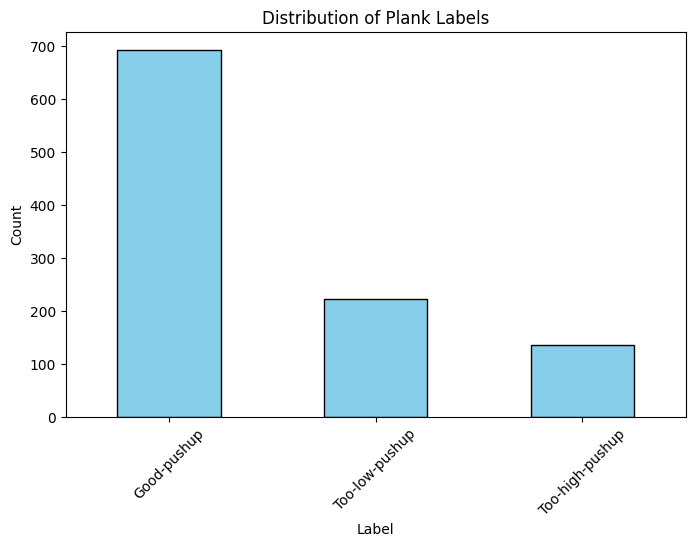

In [5]:
# 2. Distribution of Labels
label_counts = finally_pushup['label'].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Plank Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

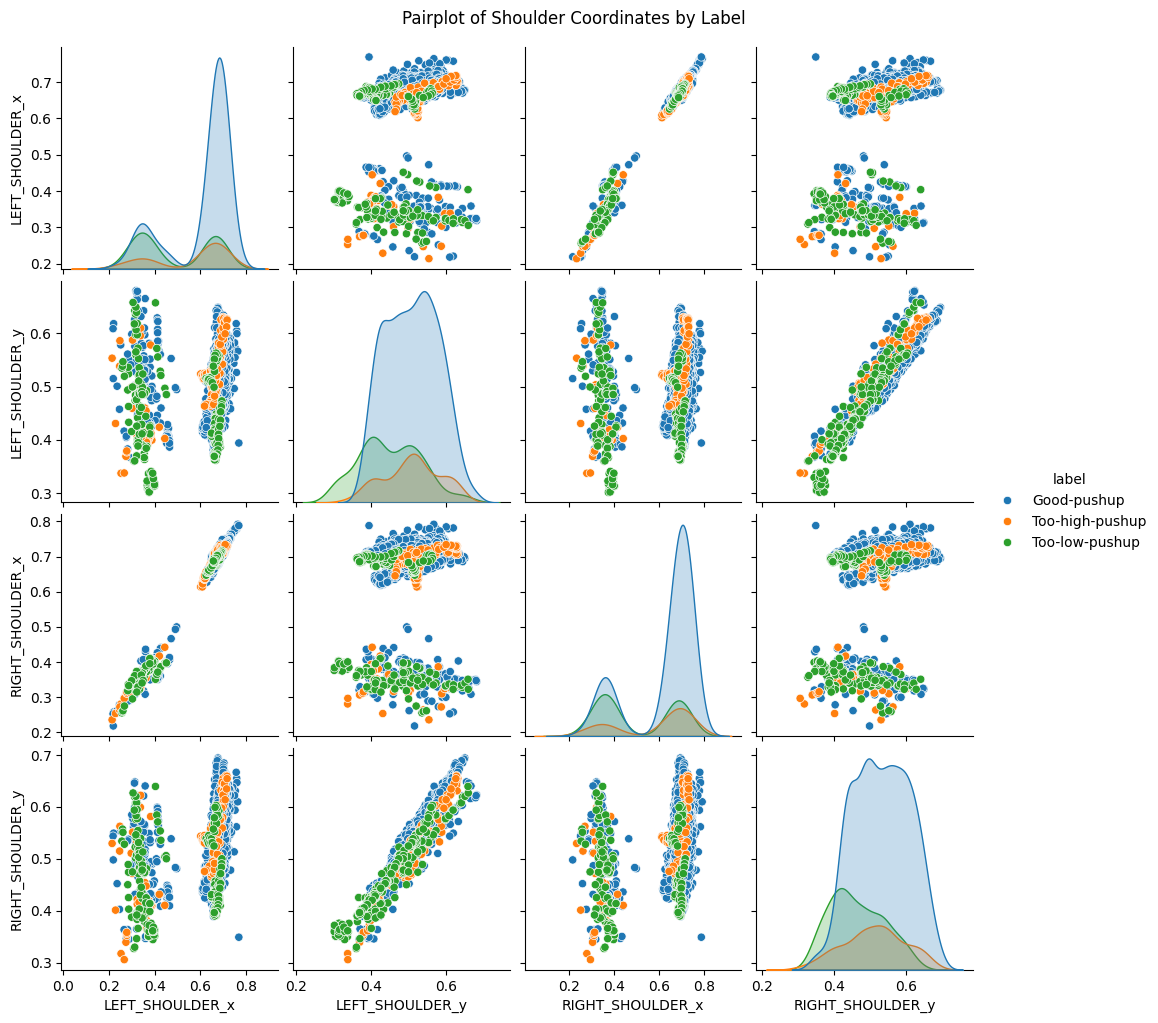

In [6]:
# 3. Pairplot for Coordinate Relationships (Sample Columns)
sample_coordinates = [
    'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'label'
]
sns.pairplot(finally_pushup[sample_coordinates], hue='label', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Shoulder Coordinates by Label', y=1.02)
plt.show()

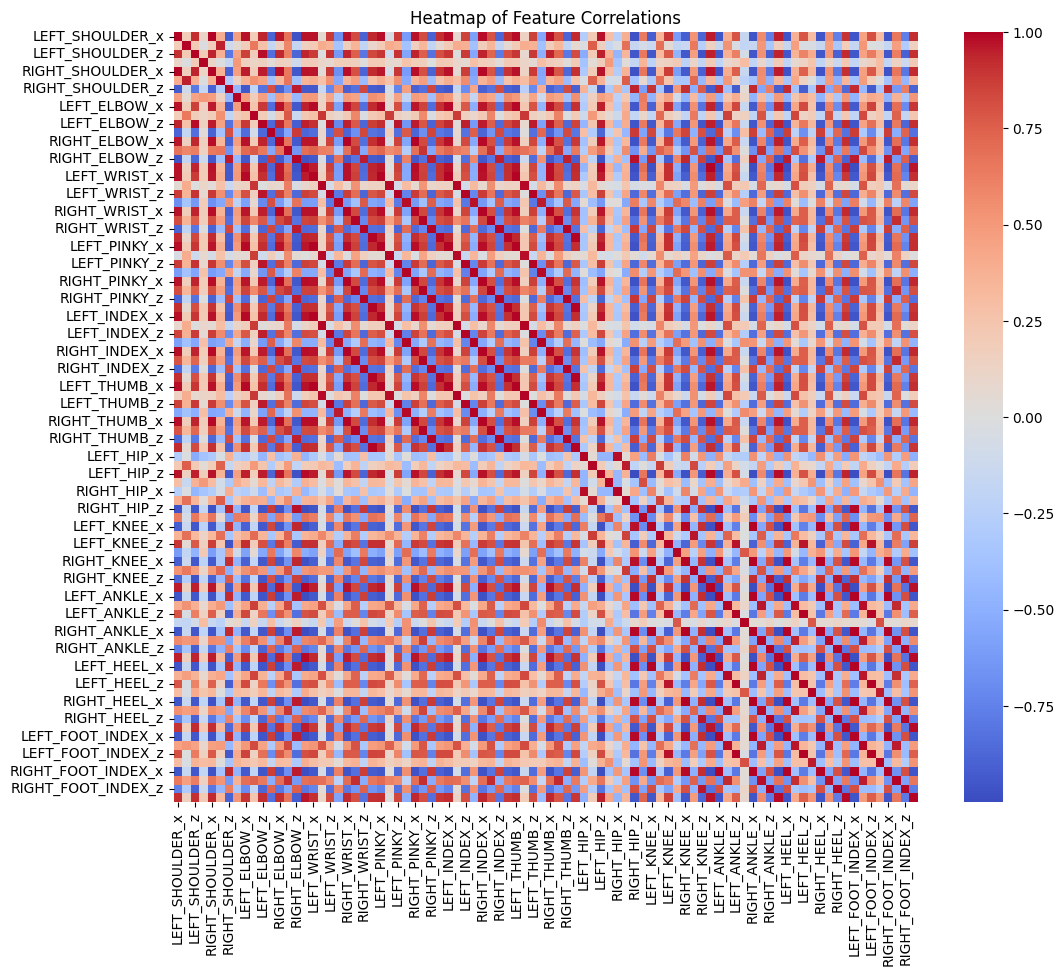

In [7]:
# 4. Heatmap of Correlations
numeric_data = finally_pushup.drop(columns=['frame', 'label'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Heatmap of Feature Correlations')
plt.show()